# Bioinformatics Project 2025 - Motif CNN & GO Prediction

**Course:** GRS34806 Deep Learning

**Authors:** Berkay Helvaci & Maurits Naber

**Date:**



## Importing Libraries

Clean the code last time! also the redundant libraries.

In [4]:
import os
import sys
from pathlib import Path

! git clone https://git.wur.nl/bioinformatics/grs34806-deep-learning-project-data.git -q
! git clone https://github.com/maussn/GRS34806-project.git -q
os.chdir(Path('grs34806-deep-learning-project-data'))

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import precision_recall_fscore_support
from datetime import datetime
import sys
import os
from pathlib import Path
import random
import seaborn as sns

## Data I/O & Tokenisation

In [3]:
# 1. read() --------------------------------------------------------------------
def read(seqfile: str, posfile: str) -> tuple[list, list]:
    """Read file with sequences and file with positive cases into lists.

    :param seqfile: file with sequences
    :type seqfile: str
    :param posfile: file with positive cases (annotated with function)
    :type posfile: str
    :return: two lists, first with sequences and second with boolean labels
    :rtype: tuple[list, list]
    """
    idlist = []
    datalist = []
    labellist = []
    with open(seqfile, 'r') as f:
        for line in f.readlines():
            line = line.rstrip().split('\t')
            idlist.append(line[0])
            datalist.append(line[1])
            labellist.append(False)
    with open(posfile, 'r') as f:
        for line in f.readlines():
            id = line.rstrip()
            try:
                i = idlist.index(id)
                labellist[i] = True
            except ValueError:
                continue
    return datalist, labellist


# 2. split_labelled() ----------------------------------------------------------
def split_labelled(datalist: list, labellist: list):
    """Return two separate sequence lists: positives & negatives."""
    pos_datalist = []
    neg_datalist = []
    for i, label in enumerate(labellist):
        if label:
            pos_datalist.append(datalist[i])
        else:
            neg_datalist.append(datalist[i])
    return pos_datalist, neg_datalist


# 3. remove_sequences() -----
def remove_sequences(datalist: list, fraction=0.5):
    """Randomly keeps half of the list"""
    random.shuffle(datalist)
    keep = round(len(datalist) * fraction)
    return datalist[:keep]


# 4. fuse_sequence_lists() ------------
def fuse_sequence_lists(pos_datalist: list, neg_datalist: list):
    """Merge postives and negetaves into one list + label"""
    pos_labels = [True for _ in pos_datalist]
    neg_labels = [False for _ in neg_datalist]
    datalist = pos_datalist + neg_datalist
    labellist = pos_labels + neg_labels
    return datalist, labellist


# 5. generate_train_test() --------
def generate_train_test(datalist: list, labellist: list, fraction: float=0.8):
    """Split up dataset in training set and test set

    :param datalist: list with sequences
    :type datalist: list
    :param labellist: list with labels
    :type labellist: list
    :param ratio: fraction to be added to the training set, remainder is added to the test set, defaults to 0.8
    :type ratio: float, optional
    :return: four lists, first two the training data and labels, second two the test data and labels
    :rtype: tuple[list, list, list, list]
    """
    c = list(zip(datalist, labellist))
    random.shuffle(c)
    datalist[:], labellist[:] = zip(*c)
    i = round(len(datalist) * fraction)
    traindatalist = datalist[:i]
    trainlabellist = labellist[:i]
    testdatalist = datalist[i:]
    testlabellist = labellist[i:]
    return traindatalist, trainlabellist,testdatalist,testlabellist


# 6. Tokenisation & Padding --------
def tokenize(data: list, map2num: dict, non_aa_num: int=20) -> list:
    """Tokenize all sequences in a list

    :param data: list of sequences to tokenize
    :type data: list
    :param map2num: ammino acid -> integer token mapping
    :type map2num: dict
    :param non_aa_num: token for non amino acid characters, defaults to 20
    :type non_aa_num: int, optional
    :return: list of tokenized sequences
    :rtype: list
    """
    seq = []
    for count, i in enumerate(data):
        seq.append([map2num.get(j,non_aa_num) for j in list(i)])
    return seq


def truncate_pad(line: list, num_steps: int, padding_token: int) -> list:
    """Truncate or pad a tokenized sequence

    :param line: tokenized sequence
    :type line: list
    :param num_steps: maximum sequence length
    :type num_steps: int
    :param padding_token: token to be used for padding
    :type padding_token: int
    :return: truncated/padded sequence
    :rtype: list
    """
    if len(line) > num_steps:
        return line[:num_steps] # Truncate
    return line + [padding_token] * (num_steps - len(line)) # Pad


def build_seq_array(lines: list, num_steps: int, non_aa_num: int=20) -> torch.tensor:
    """Truncate or pad tokenized sequences and convert to tensor

    :param lines: tokenized sequences
    :type lines: list
    :param num_steps: maximum sequence length
    :type num_steps: int
    :param non_aa_num: token for padding, defaults to 20
    :type non_aa_num: int, optional
    :return: tensor with truncated/padded tokenized sequences
    :rtype: torch.tensor
    """
    return torch.tensor([truncate_pad(l, num_steps, non_aa_num) for l in lines], dtype=torch.long)


# 7. load_array() & load_data()
def load_array(data_arrays: tuple[torch.tensor, torch.tensor], batch_size: int, is_train: bool=True) -> torch.utils.data.DataLoader:
    """Construct a PyTorch data iterator.

    Taken from d2l package"""
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)


def load_data(batch_size: int, num_steps: int, dataset: tuple[list, list]) -> torch.utils.data.DataLoader:
    """Tokenize sequence/label dataset and load into dataloader.

    :param batch_size: size of each batch
    :type batch_size: int
    :param num_steps: maximum sequence length
    :type num_steps: int
    :param dataset: first list contains sequences, second labels
    :type dataset: tuple[list, list]
    :return: torch dataloader which gives a tensor of sequences in a batch and a tensor with their labels
    :rtype: torch.utils.data.DataLoader
    """
    mapaa2num = {aa: i for (i, aa) in enumerate(list("ACDEFGHIKLMNPQRSTVWY"))}
    seq,lab = dataset
    seq = tokenize(seq, mapaa2num)
    seq_array = build_seq_array(seq, num_steps)
    data_arrays = (seq_array, torch.tensor(lab, dtype=torch.long))
    data_iter = load_array(data_arrays, batch_size)
    return data_iter


## Data Loader

In [7]:
datalist, labellist = read("len200_500_n5000nr1.seq", "len200_500_n5000nr1.pos")

batch_size = 10
num_steps = 1000 # max sequence length

traindatalist, trainlabellist, testdatalist, testlabellist = generate_train_test(datalist, labellist, 0.8)
traindataset = [traindatalist, trainlabellist]
testdataset = [testdatalist, testlabellist]

# Set batch_size and num_steps (maximum sequence length)
train_iter = load_data(batch_size, num_steps, traindataset)
test_iter = load_data(batch_size, num_steps, testdataset)

print("batch shape  :", next(iter(train_iter))[0].shape)
print("labels shape :", next(iter(train_iter))[1].shape)

batch shape  : torch.Size([10, 1000])
labels shape : torch.Size([10])


## Training / Evaluation

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
def init_weights(layer):
    if type(layer) == nn.Linear or type(layer) == nn.Conv1d:
        nn.init.xavier_uniform_(layer.weight)


class Trainer:
    def __init__(self, model, loss_fn, optimizer, device='cuda'):
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = device
        self.columns = [
            'epoch',
            'train_accuracy',
            'train_precision',
            'train_recall',
            'train_fscore',
            'train_loss',
            'test_accuracy',
            'test_precision',
            'test_recall',
            'test_fscore',
            'test_loss'
        ]
        self.df = pd.DataFrame(columns=self.columns)


    # One training epoch -------------------------------------------------------
    def _train_one_epoch(self, train_iter):
        result_loss = 0
        tpos = fpos = tneg = fneg = 0
        self.model.train(True)

        for i, (inputs, labels) in enumerate(train_iter):
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.loss_fn(outputs, labels)
            loss.backward()
            self.optimizer.step()
            result_loss += loss.item()

            # Confusion matrix calculation
            for j, l in enumerate(labels):
                o = outputs[j].tolist().index(max(outputs[j]))
                l = l.item()
                if o == 1 and l == 1:
                    tpos += 1
                elif o == 1 and l == 0:
                    fpos += 1
                elif o == 0 and l == 0:
                    tneg += 1
                elif o == 0 and l == 1:
                    fneg += 1
                else:
                    raise ValueError(f'Output or label is not rounded to zero: {o = } {l = }')

        accuracy = (tpos + tneg) / (tpos + fpos + tneg + fneg)
        precision = tpos / (tpos + fpos) if (tpos + fpos) > 0 else 0
        recall = tpos / (tpos + fneg) if (tpos + fneg) > 0 else 0
        fscore = 2 * tpos / (2*tpos + fpos + fneg) if (2*tpos + fpos + fneg) > 0 else 0

        return accuracy, precision, recall, fscore, result_loss / (i+1)

    # Evaluation epoch ---------------------------------------------------------
    def _test_one_epoch(self, test_iter):
        result_loss = 0
        tpos = fpos = tneg = fneg = 0
        self.model.eval()

        with torch.no_grad():
            for i, (inputs, labels) in enumerate(test_iter, start=1):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(inputs)
                loss = self.loss_fn(input=outputs, target=labels)
                result_loss += loss.item()

                # Confusion matrix calculation
                for j, l in enumerate(labels):
                    o = outputs[j].tolist().index(max(outputs[j]))
                    l = l.item()
                    if o == 1 and l == 1:
                        tpos += 1
                    elif o == 1 and l == 0:
                        fpos += 1
                    elif o == 0 and l == 0:
                        tneg += 1
                    elif o == 0 and l == 1:
                        fneg += 1
                    else:
                        raise ValueError(f'Output or label is not rounded to zero: {o = } {l = }')

        accuracy = (tpos + tneg) / (tpos + fpos + tneg + fneg)
        precision = tpos / (tpos + fpos) if (tpos + fpos) > 0 else 0
        recall = tpos / (tpos + fneg) if (tpos + fneg) > 0 else 0
        fscore = 2 * tpos / (2*tpos + fpos + fneg) if (2*tpos + fpos + fneg) > 0 else 0

        return accuracy, precision, recall, fscore, result_loss / (i+1)


    def _load_into_dict(self, epoch, train_stats, test_stats):
        row = [epoch] + list(train_stats) + list(test_stats)
        row = pd.DataFrame(row, index=self.columns).T
        self.df = pd.concat([self.df, row], axis=0)


    def train(self, epochs, train_iter, test_iter):

        for epoch in range(epochs):
            train_stats = self._train_one_epoch(train_iter)

            test_stats = self._test_one_epoch(test_iter)
            self._load_into_dict(epoch, train_stats, test_stats)
            print(f"[epoch {epoch:02d}] "
                  f"train-loss={train_stats[-1]:.4f} | "
                  f"test-loss={test_stats[-1]:.4f} | "
                  f"train-acc={train_stats[0]:.4f} | "
                  f"test-acc={test_stats[0]:.4f} | "
                  f"P={test_stats[1]:.4f} | R={test_stats[2]:.4f} | F1={test_stats[3]:.4f}")

        return self.df

In [10]:
class BerryCNN1D(nn.Module):
    """1D Convolutional Neural Network for protein function classification"""
    def __init__(self, vocab_size: int = 21,
                 dropout_rate = 0, conv_channels: int = 128,
                 use_bias: bool = False):

        super().__init__()

        self.embedding = nn.Embedding(vocab_size, vocab_size)

        # CNN model for binary classification
        self.conv1 = nn.Sequential(
            # conv block 1
            nn.Conv1d(in_channels=vocab_size, out_channels=conv_channels, kernel_size=3, padding='same', bias=use_bias),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            # conv block 2
            nn.Conv1d(in_channels=conv_channels, out_channels=conv_channels, kernel_size=3, padding='same', bias=use_bias),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1)
        )


        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Sequential(
            # flatten + classification head
            nn.Flatten(1, -1),
            nn.LazyLinear(out_features=2, bias=use_bias)  # binary classification
        )


    def forward(self, x: torch.tensor, targets: torch.tensor = None):
        """Predict protein function class (0 or 1)"""
        x = self.embedding(x).permute(0,2,1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        return self.fc(x)


## Training the Model

In [11]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'dropout_rate': [0, 0.3],
    'lr': [0.01, 0.001],
    'momentum': [0, 0.5],
    'conv_channels': [64, 128]
}

grid = list(ParameterGrid(param_grid))

best_acc = 0
best_params = None

df = None

for params in grid:
    print("Current hyper-parameters:", params)
    model = BerryCNN1D(
        vocab_size=21,
        dropout_rate=params['dropout_rate'],
        conv_channels=params['conv_channels']
    )
    model.apply(init_weights)

    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=params['lr'],
        momentum=params['momentum']
    )

    loss_fn = nn.CrossEntropyLoss()
    trainer = Trainer(model, loss_fn, optimizer, device)

    out_df = trainer.train(epochs=10, train_iter=train_iter, test_iter=test_iter)

    for p in params.keys():
        out_df[p] = params[p]

    acc = out_df['test_accuracy'].max()

    if acc >= best_acc:
        best_acc = []
        best_acc = acc
        best_params = params
        print(f"New best accuracy {best_acc:.4f} with {best_params} \n")

    if type(df) != pd.DataFrame:
        df = out_df
    else:
        df = pd.concat([df, out_df], axis=0)

print("Best hyper‑parameters found:", best_params)

Current hyper-parameters: {'conv_channels': 64, 'dropout_rate': 0, 'lr': 0.01, 'momentum': 0}


<ipython-input-9-683adbe3301c>:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.4473 | test-loss=0.0441 | train-acc=0.7605 | test-acc=0.9990 | P=0.9981 | R=1.0000 | F1=0.9990
[epoch 01] train-loss=0.0196 | test-loss=0.0093 | train-acc=0.9992 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 02] train-loss=0.0068 | test-loss=0.0045 | train-acc=0.9995 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 03] train-loss=0.0042 | test-loss=0.0030 | train-acc=0.9998 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 04] train-loss=0.0030 | test-loss=0.0021 | train-acc=0.9998 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 05] train-loss=0.0023 | test-loss=0.0017 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 06] train-loss=0.0018 | test-loss=0.0013 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 07] train-loss=0.0015 | test-loss=0.0013 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 08] train-loss=0.0013 | test-loss=0.0010 

<ipython-input-9-683adbe3301c>:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.1593 | test-loss=0.0078 | train-acc=0.9337 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 01] train-loss=0.0044 | test-loss=0.0031 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 02] train-loss=0.0021 | test-loss=0.0019 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 03] train-loss=0.0013 | test-loss=0.0014 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 04] train-loss=0.0010 | test-loss=0.0011 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 05] train-loss=0.0008 | test-loss=0.0009 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 06] train-loss=0.0006 | test-loss=0.0008 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 07] train-loss=0.0005 | test-loss=0.0007 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 08] train-loss=0.0004 | test-loss=0.0006 

<ipython-input-9-683adbe3301c>:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.7035 | test-loss=0.6826 | train-acc=0.5045 | test-acc=0.5390 | P=0.5675 | R=0.4769 | F1=0.5183
[epoch 01] train-loss=0.6851 | test-loss=0.6702 | train-acc=0.5605 | test-acc=0.5750 | P=0.5604 | R=0.8481 | F1=0.6748
[epoch 02] train-loss=0.6657 | test-loss=0.6565 | train-acc=0.6310 | test-acc=0.6230 | P=0.8824 | R=0.3173 | F1=0.4668
[epoch 03] train-loss=0.6267 | test-loss=0.5976 | train-acc=0.7220 | test-acc=0.7510 | P=0.8538 | R=0.6288 | F1=0.7243
[epoch 04] train-loss=0.5370 | test-loss=0.4589 | train-acc=0.8570 | test-acc=0.9550 | P=0.9857 | R=0.9269 | F1=0.9554
[epoch 05] train-loss=0.3603 | test-loss=0.2700 | train-acc=0.9895 | test-acc=0.9960 | P=0.9924 | R=1.0000 | F1=0.9962
[epoch 06] train-loss=0.2055 | test-loss=0.1541 | train-acc=0.9990 | test-acc=0.9970 | P=0.9943 | R=1.0000 | F1=0.9971
[epoch 07] train-loss=0.1196 | test-loss=0.0940 | train-acc=0.9995 | test-acc=0.9970 | P=0.9943 | R=1.0000 | F1=0.9971
[epoch 08] train-loss=0.0766 | test-loss=0.0642 

<ipython-input-9-683adbe3301c>:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.6966 | test-loss=0.6864 | train-acc=0.5002 | test-acc=0.5140 | P=0.5500 | R=0.3596 | F1=0.4349
[epoch 01] train-loss=0.6840 | test-loss=0.6629 | train-acc=0.5590 | test-acc=0.6290 | P=0.5995 | R=0.8635 | F1=0.7076
[epoch 02] train-loss=0.5593 | test-loss=0.3560 | train-acc=0.8650 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 03] train-loss=0.1860 | test-loss=0.0907 | train-acc=0.9992 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 04] train-loss=0.0578 | test-loss=0.0404 | train-acc=0.9995 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 05] train-loss=0.0295 | test-loss=0.0244 | train-acc=0.9998 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 06] train-loss=0.0189 | test-loss=0.0172 | train-acc=0.9998 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 07] train-loss=0.0137 | test-loss=0.0131 | train-acc=0.9998 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 08] train-loss=0.0106 | test-loss=0.0105 

<ipython-input-9-683adbe3301c>:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.6026 | test-loss=0.1952 | train-acc=0.6530 | test-acc=0.9950 | P=0.9905 | R=1.0000 | F1=0.9952
[epoch 01] train-loss=0.1435 | test-loss=0.0372 | train-acc=0.9580 | test-acc=0.9950 | P=0.9905 | R=1.0000 | F1=0.9952
[epoch 02] train-loss=0.0524 | test-loss=0.0110 | train-acc=0.9858 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 03] train-loss=0.0369 | test-loss=0.0081 | train-acc=0.9900 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 04] train-loss=0.0270 | test-loss=0.0052 | train-acc=0.9915 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 05] train-loss=0.0237 | test-loss=0.0077 | train-acc=0.9940 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 06] train-loss=0.0216 | test-loss=0.0068 | train-acc=0.9955 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 07] train-loss=0.0211 | test-loss=0.0033 | train-acc=0.9955 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 08] train-loss=0.0207 | test-loss=0.0044 

<ipython-input-9-683adbe3301c>:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.4366 | test-loss=0.0229 | train-acc=0.7542 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 01] train-loss=0.0356 | test-loss=0.0106 | train-acc=0.9912 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 02] train-loss=0.0244 | test-loss=0.0062 | train-acc=0.9948 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 03] train-loss=0.0188 | test-loss=0.0068 | train-acc=0.9955 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 04] train-loss=0.0096 | test-loss=0.0046 | train-acc=0.9982 | test-acc=0.9990 | P=0.9981 | R=1.0000 | F1=0.9990
[epoch 05] train-loss=0.0073 | test-loss=0.0025 | train-acc=0.9988 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 06] train-loss=0.0065 | test-loss=0.0026 | train-acc=0.9982 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 07] train-loss=0.0044 | test-loss=0.0024 | train-acc=0.9995 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 08] train-loss=0.0050 | test-loss=0.0016 

<ipython-input-9-683adbe3301c>:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.7633 | test-loss=0.6884 | train-acc=0.4968 | test-acc=0.5100 | P=0.5852 | R=0.1981 | F1=0.2960
[epoch 01] train-loss=0.7195 | test-loss=0.6728 | train-acc=0.5100 | test-acc=0.5670 | P=0.5589 | R=0.7942 | F1=0.6561
[epoch 02] train-loss=0.6985 | test-loss=0.6517 | train-acc=0.5375 | test-acc=0.7220 | P=0.7597 | R=0.6808 | F1=0.7181
[epoch 03] train-loss=0.6628 | test-loss=0.5927 | train-acc=0.6132 | test-acc=0.9160 | P=0.8759 | R=0.9769 | F1=0.9236
[epoch 04] train-loss=0.5928 | test-loss=0.4925 | train-acc=0.7245 | test-acc=0.9870 | P=0.9756 | R=1.0000 | F1=0.9877
[epoch 05] train-loss=0.4836 | test-loss=0.3565 | train-acc=0.8190 | test-acc=0.9990 | P=0.9981 | R=1.0000 | F1=0.9990
[epoch 06] train-loss=0.3605 | test-loss=0.2285 | train-acc=0.8922 | test-acc=0.9990 | P=0.9981 | R=1.0000 | F1=0.9990
[epoch 07] train-loss=0.2747 | test-loss=0.1483 | train-acc=0.9290 | test-acc=0.9970 | P=0.9943 | R=1.0000 | F1=0.9971
[epoch 08] train-loss=0.2093 | test-loss=0.0953 

<ipython-input-9-683adbe3301c>:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.7220 | test-loss=0.6688 | train-acc=0.5072 | test-acc=0.5380 | P=0.5298 | R=0.9904 | F1=0.6903
[epoch 01] train-loss=0.6366 | test-loss=0.4940 | train-acc=0.6378 | test-acc=0.9990 | P=0.9981 | R=1.0000 | F1=0.9990
[epoch 02] train-loss=0.4142 | test-loss=0.2130 | train-acc=0.8690 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 03] train-loss=0.2519 | test-loss=0.0994 | train-acc=0.9377 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 04] train-loss=0.1649 | test-loss=0.0591 | train-acc=0.9583 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 05] train-loss=0.1345 | test-loss=0.0432 | train-acc=0.9627 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 06] train-loss=0.1070 | test-loss=0.0335 | train-acc=0.9710 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 07] train-loss=0.0968 | test-loss=0.0292 | train-acc=0.9745 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 08] train-loss=0.0782 | test-loss=0.0241 

<ipython-input-9-683adbe3301c>:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.2003 | test-loss=0.0157 | train-acc=0.9205 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 01] train-loss=0.0089 | test-loss=0.0054 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 02] train-loss=0.0040 | test-loss=0.0031 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 03] train-loss=0.0025 | test-loss=0.0021 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 04] train-loss=0.0018 | test-loss=0.0016 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 05] train-loss=0.0014 | test-loss=0.0013 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 06] train-loss=0.0012 | test-loss=0.0011 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 07] train-loss=0.0010 | test-loss=0.0009 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 08] train-loss=0.0008 | test-loss=0.0008 

<ipython-input-9-683adbe3301c>:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.1454 | test-loss=0.0066 | train-acc=0.9337 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 01] train-loss=0.0038 | test-loss=0.0027 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 02] train-loss=0.0019 | test-loss=0.0016 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 03] train-loss=0.0012 | test-loss=0.0012 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 04] train-loss=0.0009 | test-loss=0.0009 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 05] train-loss=0.0007 | test-loss=0.0008 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 06] train-loss=0.0006 | test-loss=0.0006 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 07] train-loss=0.0005 | test-loss=0.0006 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 08] train-loss=0.0004 | test-loss=0.0005 

<ipython-input-9-683adbe3301c>:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.6912 | test-loss=0.6771 | train-acc=0.5310 | test-acc=0.5470 | P=0.5356 | R=0.9692 | F1=0.6899
[epoch 01] train-loss=0.6635 | test-loss=0.6234 | train-acc=0.6522 | test-acc=0.8210 | P=0.7549 | R=0.9712 | F1=0.8495
[epoch 02] train-loss=0.5465 | test-loss=0.4256 | train-acc=0.9350 | test-acc=0.9950 | P=0.9905 | R=1.0000 | F1=0.9952
[epoch 03] train-loss=0.3028 | test-loss=0.1943 | train-acc=0.9998 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 04] train-loss=0.1364 | test-loss=0.0934 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 05] train-loss=0.0717 | test-loss=0.0548 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 06] train-loss=0.0448 | test-loss=0.0367 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 07] train-loss=0.0313 | test-loss=0.0270 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 08] train-loss=0.0236 | test-loss=0.0211 

<ipython-input-9-683adbe3301c>:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.6947 | test-loss=0.6558 | train-acc=0.5195 | test-acc=0.5950 | P=0.5626 | R=0.9942 | F1=0.7186
[epoch 01] train-loss=0.5590 | test-loss=0.3783 | train-acc=0.8702 | test-acc=0.9990 | P=0.9981 | R=1.0000 | F1=0.9990
[epoch 02] train-loss=0.2137 | test-loss=0.1046 | train-acc=0.9998 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 03] train-loss=0.0662 | test-loss=0.0426 | train-acc=0.9998 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 04] train-loss=0.0316 | test-loss=0.0242 | train-acc=0.9998 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 05] train-loss=0.0195 | test-loss=0.0163 | train-acc=0.9998 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 06] train-loss=0.0137 | test-loss=0.0120 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 07] train-loss=0.0104 | test-loss=0.0094 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 08] train-loss=0.0083 | test-loss=0.0077 

<ipython-input-9-683adbe3301c>:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.3869 | test-loss=0.0343 | train-acc=0.8073 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 01] train-loss=0.0526 | test-loss=0.0163 | train-acc=0.9875 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 02] train-loss=0.0263 | test-loss=0.0068 | train-acc=0.9940 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 03] train-loss=0.0151 | test-loss=0.0045 | train-acc=0.9960 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 04] train-loss=0.0124 | test-loss=0.0031 | train-acc=0.9968 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 05] train-loss=0.0105 | test-loss=0.0026 | train-acc=0.9972 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 06] train-loss=0.0105 | test-loss=0.0025 | train-acc=0.9978 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 07] train-loss=0.0052 | test-loss=0.0015 | train-acc=0.9992 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 08] train-loss=0.0059 | test-loss=0.0015 

<ipython-input-9-683adbe3301c>:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.3032 | test-loss=0.0183 | train-acc=0.8482 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 01] train-loss=0.0233 | test-loss=0.0034 | train-acc=0.9938 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 02] train-loss=0.0147 | test-loss=0.0027 | train-acc=0.9970 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 03] train-loss=0.0083 | test-loss=0.0017 | train-acc=0.9972 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 04] train-loss=0.0050 | test-loss=0.0021 | train-acc=0.9988 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 05] train-loss=0.0054 | test-loss=0.0026 | train-acc=0.9985 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 06] train-loss=0.0051 | test-loss=0.0019 | train-acc=0.9988 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 07] train-loss=0.0027 | test-loss=0.0010 | train-acc=0.9995 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 08] train-loss=0.0031 | test-loss=0.0007 

<ipython-input-9-683adbe3301c>:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.7327 | test-loss=0.6814 | train-acc=0.5052 | test-acc=0.5590 | P=0.6000 | R=0.4558 | F1=0.5180
[epoch 01] train-loss=0.6989 | test-loss=0.6509 | train-acc=0.5407 | test-acc=0.7810 | P=0.7980 | R=0.7750 | F1=0.7863
[epoch 02] train-loss=0.6485 | test-loss=0.5735 | train-acc=0.6282 | test-acc=0.9860 | P=1.0000 | R=0.9731 | F1=0.9864
[epoch 03] train-loss=0.5637 | test-loss=0.4580 | train-acc=0.7628 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 04] train-loss=0.4722 | test-loss=0.3399 | train-acc=0.8355 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 05] train-loss=0.4071 | test-loss=0.2624 | train-acc=0.8462 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 06] train-loss=0.3606 | test-loss=0.2070 | train-acc=0.8512 | test-acc=0.9990 | P=0.9981 | R=1.0000 | F1=0.9990
[epoch 07] train-loss=0.3143 | test-loss=0.1577 | train-acc=0.8690 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 08] train-loss=0.2755 | test-loss=0.1186 

<ipython-input-9-683adbe3301c>:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.7109 | test-loss=0.6522 | train-acc=0.5220 | test-acc=0.7120 | P=0.9056 | R=0.4981 | F1=0.6427
[epoch 01] train-loss=0.5907 | test-loss=0.4010 | train-acc=0.6910 | test-acc=0.9990 | P=0.9981 | R=1.0000 | F1=0.9990
[epoch 02] train-loss=0.3565 | test-loss=0.1776 | train-acc=0.8970 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 03] train-loss=0.2197 | test-loss=0.0876 | train-acc=0.9450 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 04] train-loss=0.1541 | test-loss=0.0525 | train-acc=0.9603 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 05] train-loss=0.1123 | test-loss=0.0364 | train-acc=0.9680 | test-acc=0.9990 | P=0.9981 | R=1.0000 | F1=0.9990
[epoch 06] train-loss=0.0853 | test-loss=0.0259 | train-acc=0.9780 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 07] train-loss=0.0723 | test-loss=0.0249 | train-acc=0.9772 | test-acc=0.9990 | P=0.9981 | R=1.0000 | F1=0.9990
[epoch 08] train-loss=0.0531 | test-loss=0.0208 

## Training on reduced datasets

### Half of positives

In [40]:
datalist, labellist = read("len200_500_n5000nr1.seq", "len200_500_n5000nr1.pos")
pos_datalist, neg_datalist = split_labelled(datalist, labellist)
pos_datalist = remove_sequences(pos_datalist, 0.5)
datalist, labellist = fuse_sequence_lists(pos_datalist, neg_datalist)

batch_size = 10
num_steps = 1000 # max sequence length

traindatalist, trainlabellist, testdatalist, testlabellist = generate_train_test(datalist, labellist, 0.8)
traindataset = [traindatalist, trainlabellist]
testdataset = [testdatalist, testlabellist]

# Set batch_size and num_steps (maximum sequence length)
train_iter = load_data(batch_size, num_steps, traindataset)
test_iter = load_data(batch_size, num_steps, testdataset)

print("batch shape  :", next(iter(train_iter))[0].shape)
print("labels shape :", next(iter(train_iter))[1].shape)

batch shape  : torch.Size([10, 1000])
labels shape : torch.Size([10])


In [41]:
model = BerryCNN1D(vocab_size=21,dropout_rate=0,conv_channels=64)
model.apply(init_weights)
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.01,
    momentum=0.5
)
loss_fn = nn.CrossEntropyLoss()

trainer = Trainer(model, loss_fn, optimizer, device)
df = trainer.train(epochs=10, train_iter=train_iter, test_iter=test_iter)

<ipython-input-32-1cb05001b72f>:128: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.2455 | test-loss=0.0126 | train-acc=0.8971 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 01] train-loss=0.0077 | test-loss=0.0040 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 02] train-loss=0.0034 | test-loss=0.0021 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 03] train-loss=0.0021 | test-loss=0.0014 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 04] train-loss=0.0016 | test-loss=0.0011 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 05] train-loss=0.0012 | test-loss=0.0009 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 06] train-loss=0.0010 | test-loss=0.0007 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 07] train-loss=0.0008 | test-loss=0.0006 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 08] train-loss=0.0007 | test-loss=0.0005 

In [42]:
df.to_csv('half_pos_len200_500_n5000nr1.csv')

### Half of negatives

In [43]:
datalist, labellist = read("len200_500_n5000nr1.seq", "len200_500_n5000nr1.pos")
pos_datalist, neg_datalist = split_labelled(datalist, labellist)
neg_datalist = remove_sequences(neg_datalist, 0.5)
datalist, labellist = fuse_sequence_lists(pos_datalist, neg_datalist)

batch_size = 10
num_steps = 1000 # max sequence length

traindatalist, trainlabellist, testdatalist, testlabellist = generate_train_test(datalist, labellist, 0.8)
traindataset = [traindatalist, trainlabellist]
testdataset = [testdatalist, testlabellist]

# Set batch_size and num_steps (maximum sequence length)
train_iter = load_data(batch_size, num_steps, traindataset)
test_iter = load_data(batch_size, num_steps, testdataset)

print("batch shape  :", next(iter(train_iter))[0].shape)
print("labels shape :", next(iter(train_iter))[1].shape)

batch shape  : torch.Size([10, 1000])
labels shape : torch.Size([10])


In [44]:
model = BerryCNN1D(vocab_size=21,dropout_rate=0,conv_channels=64)
model.apply(init_weights)
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.01,
    momentum=0.5
)
loss_fn = nn.CrossEntropyLoss()

trainer = Trainer(model, loss_fn, optimizer, device)
df = trainer.train(epochs=10, train_iter=train_iter, test_iter=test_iter)

<ipython-input-32-1cb05001b72f>:128: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.5165 | test-loss=0.0688 | train-acc=0.7465 | test-acc=0.9960 | P=0.9941 | R=1.0000 | F1=0.9970
[epoch 01] train-loss=0.0241 | test-loss=0.0087 | train-acc=0.9983 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 02] train-loss=0.0067 | test-loss=0.0043 | train-acc=0.9993 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 03] train-loss=0.0038 | test-loss=0.0029 | train-acc=0.9997 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 04] train-loss=0.0025 | test-loss=0.0022 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 05] train-loss=0.0019 | test-loss=0.0018 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 06] train-loss=0.0015 | test-loss=0.0016 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 07] train-loss=0.0012 | test-loss=0.0014 | train-acc=1.0000 | test-acc=1.0000 | P=1.0000 | R=1.0000 | F1=1.0000
[epoch 08] train-loss=0.0010 | test-loss=0.0012 

In [45]:
df.to_csv('half_neg_len200_500_n5000nr1.csv')

## Training on GO annotations

In [37]:
datalist, labellist = read("expr5Tseq_filtGO_100-1000.lis", "GO_3A0005576.annotprot")

batch_size = 10
num_steps = 1000 # max sequence length

traindatalist, trainlabellist, testdatalist, testlabellist = generate_train_test(datalist, labellist, 0.8)
traindataset = [traindatalist, trainlabellist]
testdataset = [testdatalist, testlabellist]

# Set batch_size and num_steps (maximum sequence length)
train_iter = load_data(batch_size, num_steps, traindataset)
test_iter = load_data(batch_size, num_steps, testdataset)


In [46]:
model = BerryCNN1D(vocab_size=21,dropout_rate=0,conv_channels=64)
model.apply(init_weights)
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.01,
    momentum=0.5
)
loss_fn = nn.CrossEntropyLoss()

trainer = Trainer(model, loss_fn, optimizer, device)
df = trainer.train(epochs=10, train_iter=train_iter, test_iter=test_iter)

df.to_csv("GO_3A0005576_full_set.csv")

KeyboardInterrupt: 

In [54]:
datalist, labellist = read("expr5Tseq_filtGO_100-1000.lis", "GO_3A0005576.annotprot")
pos_datalist, neg_datalist = split_labelled(datalist, labellist)
neg_datalist = remove_sequences(neg_datalist, 0.3)
datalist, labellist = fuse_sequence_lists(pos_datalist, neg_datalist)

batch_size = 10
num_steps = 1000 # max sequence length

traindatalist, trainlabellist, testdatalist, testlabellist = generate_train_test(datalist, labellist, 0.8)
traindataset = [traindatalist, trainlabellist]
testdataset = [testdatalist, testlabellist]

# Set batch_size and num_steps (maximum sequence length)
train_iter = load_data(batch_size, num_steps, traindataset)
test_iter = load_data(batch_size, num_steps, testdataset)

# Train model
model = BerryCNN1D(vocab_size=21,dropout_rate=0,conv_channels=64)
model.apply(init_weights)
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.01,
    momentum=0.5
)
loss_fn = nn.CrossEntropyLoss()

trainer = Trainer(model, loss_fn, optimizer, device)
df = trainer.train(epochs=10, train_iter=train_iter, test_iter=test_iter)

<ipython-input-32-1cb05001b72f>:128: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.4077 | test-loss=0.4206 | train-acc=0.8639 | test-acc=0.8444 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 01] train-loss=0.3867 | test-loss=0.4189 | train-acc=0.8683 | test-acc=0.8444 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 02] train-loss=0.3713 | test-loss=0.4366 | train-acc=0.8683 | test-acc=0.8444 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 03] train-loss=0.3568 | test-loss=0.4391 | train-acc=0.8689 | test-acc=0.8444 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 04] train-loss=0.3365 | test-loss=0.4043 | train-acc=0.8689 | test-acc=0.8444 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 05] train-loss=0.3186 | test-loss=0.4116 | train-acc=0.8739 | test-acc=0.8489 | P=0.6667 | R=0.0571 | F1=0.1053
[epoch 06] train-loss=0.3004 | test-loss=0.4579 | train-acc=0.8778 | test-acc=0.8444 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 07] train-loss=0.2654 | test-loss=0.4689 | train-acc=0.8911 | test-acc=0.8444 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 08] train-loss=0.2379 | test-loss=0.4073 

In [55]:
go_annotations = ["GO_3A0005576", "GO_3A0005739", "GO_3A0007165", "GO_3A0043066", "GO_3A0055085"]

for go in go_annotations:
    datalist, labellist = read("expr5Tseq_filtGO_100-1000.lis", f"{go}.annotprot")
    pos_datalist, neg_datalist = split_labelled(datalist, labellist)
    neg_datalist = remove_sequences(neg_datalist, 0.3)
    datalist, labellist = fuse_sequence_lists(pos_datalist, neg_datalist)

    batch_size = 10
    num_steps = 1000 # max sequence length

    traindatalist, trainlabellist, testdatalist, testlabellist = generate_train_test(datalist, labellist, 0.8)
    traindataset = [traindatalist, trainlabellist]
    testdataset = [testdatalist, testlabellist]

    # Set batch_size and num_steps (maximum sequence length)
    train_iter = load_data(batch_size, num_steps, traindataset)
    test_iter = load_data(batch_size, num_steps, testdataset)

    # Train model
    model = BerryCNN1D(vocab_size=21,dropout_rate=0,conv_channels=64)
    model.apply(init_weights)
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=0.01,
        momentum=0.5
    )
    loss_fn = nn.CrossEntropyLoss()

    trainer = Trainer(model, loss_fn, optimizer, device)
    df = trainer.train(epochs=10, train_iter=train_iter, test_iter=test_iter)

    df.to_csv(f"{go}.csv")

<ipython-input-32-1cb05001b72f>:128: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.4231 | test-loss=0.3598 | train-acc=0.8544 | test-acc=0.8778 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 01] train-loss=0.4010 | test-loss=0.3579 | train-acc=0.8600 | test-acc=0.8778 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 02] train-loss=0.3859 | test-loss=0.3750 | train-acc=0.8600 | test-acc=0.8778 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 03] train-loss=0.3765 | test-loss=0.3477 | train-acc=0.8600 | test-acc=0.8778 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 04] train-loss=0.3599 | test-loss=0.3410 | train-acc=0.8617 | test-acc=0.8778 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 05] train-loss=0.3338 | test-loss=0.3517 | train-acc=0.8661 | test-acc=0.8778 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 06] train-loss=0.3054 | test-loss=0.3894 | train-acc=0.8706 | test-acc=0.8733 | P=0.4500 | R=0.1636 | F1=0.2400
[epoch 07] train-loss=0.2758 | test-loss=0.3268 | train-acc=0.8828 | test-acc=0.8822 | P=0.6250 | R=0.0909 | F1=0.1587
[epoch 08] train-loss=0.2445 | test-loss=0.3242 

<ipython-input-32-1cb05001b72f>:128: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.5208 | test-loss=0.5203 | train-acc=0.7966 | test-acc=0.7844 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 01] train-loss=0.4874 | test-loss=0.4987 | train-acc=0.8024 | test-acc=0.7844 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 02] train-loss=0.4711 | test-loss=0.5204 | train-acc=0.8051 | test-acc=0.7844 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 03] train-loss=0.4476 | test-loss=0.5048 | train-acc=0.8051 | test-acc=0.7844 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 04] train-loss=0.4277 | test-loss=0.5595 | train-acc=0.8061 | test-acc=0.7844 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 05] train-loss=0.3928 | test-loss=0.5967 | train-acc=0.8278 | test-acc=0.7844 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 06] train-loss=0.3722 | test-loss=0.5335 | train-acc=0.8405 | test-acc=0.7865 | P=0.6667 | R=0.0196 | F1=0.0381
[epoch 07] train-loss=0.3291 | test-loss=0.5762 | train-acc=0.8595 | test-acc=0.7865 | P=1.0000 | R=0.0098 | F1=0.0194
[epoch 08] train-loss=0.2912 | test-loss=0.5703 

<ipython-input-32-1cb05001b72f>:128: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.4951 | test-loss=0.4760 | train-acc=0.8143 | test-acc=0.8112 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 01] train-loss=0.4715 | test-loss=0.5423 | train-acc=0.8175 | test-acc=0.8112 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 02] train-loss=0.4640 | test-loss=0.4775 | train-acc=0.8223 | test-acc=0.8112 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 03] train-loss=0.4563 | test-loss=0.4783 | train-acc=0.8218 | test-acc=0.8112 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 04] train-loss=0.4406 | test-loss=0.5248 | train-acc=0.8223 | test-acc=0.8133 | P=1.0000 | R=0.0114 | F1=0.0225
[epoch 05] train-loss=0.4198 | test-loss=0.4709 | train-acc=0.8250 | test-acc=0.8112 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 06] train-loss=0.3915 | test-loss=0.5378 | train-acc=0.8245 | test-acc=0.8112 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 07] train-loss=0.3732 | test-loss=0.4754 | train-acc=0.8347 | test-acc=0.8112 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 08] train-loss=0.3400 | test-loss=0.4730 

<ipython-input-32-1cb05001b72f>:128: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.3082 | test-loss=0.3094 | train-acc=0.9083 | test-acc=0.9055 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 01] train-loss=0.2960 | test-loss=0.3015 | train-acc=0.9141 | test-acc=0.9055 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 02] train-loss=0.2899 | test-loss=0.3280 | train-acc=0.9141 | test-acc=0.9055 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 03] train-loss=0.2834 | test-loss=0.3075 | train-acc=0.9141 | test-acc=0.9055 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 04] train-loss=0.2720 | test-loss=0.3138 | train-acc=0.9141 | test-acc=0.9055 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 05] train-loss=0.2686 | test-loss=0.3051 | train-acc=0.9141 | test-acc=0.9055 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 06] train-loss=0.2527 | test-loss=0.3083 | train-acc=0.9141 | test-acc=0.9055 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 07] train-loss=0.2388 | test-loss=0.3225 | train-acc=0.9141 | test-acc=0.9055 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 08] train-loss=0.2279 | test-loss=0.3022 

<ipython-input-32-1cb05001b72f>:128: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=0.3618 | test-loss=0.4198 | train-acc=0.8951 | test-acc=0.9043 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 01] train-loss=0.3356 | test-loss=0.3387 | train-acc=0.8951 | test-acc=0.9043 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 02] train-loss=0.3110 | test-loss=0.2855 | train-acc=0.8951 | test-acc=0.9043 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 03] train-loss=0.2862 | test-loss=0.2794 | train-acc=0.8951 | test-acc=0.9043 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 04] train-loss=0.2568 | test-loss=0.2742 | train-acc=0.9019 | test-acc=0.9043 | P=0.0000 | R=0.0000 | F1=0.0000
[epoch 05] train-loss=0.2289 | test-loss=0.2708 | train-acc=0.9122 | test-acc=0.9021 | P=0.4615 | R=0.1429 | F1=0.2182
[epoch 06] train-loss=0.1995 | test-loss=0.3281 | train-acc=0.9225 | test-acc=0.8884 | P=0.4222 | R=0.4524 | F1=0.4368
[epoch 07] train-loss=0.1852 | test-loss=0.2456 | train-acc=0.9333 | test-acc=0.8998 | P=0.4000 | R=0.0952 | F1=0.1538
[epoch 08] train-loss=0.1542 | test-loss=0.3047 

# Multi-label prediction

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import sys
import os
from pathlib import Path
import random
import seaborn as sns
import pandas as pd


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from functools import total_ordering
def init_weights(layer):
    if type(layer) == nn.Linear or type(layer) == nn.Conv1d:
        nn.init.xavier_uniform_(layer.weight)

# Load data multiple labels

In [ ]:
def read_multiple_pos(seqfile: str, posfiles: list[str]) -> tuple[list, list]:
    """Read file with sequences and file with positive cases into lists.

    :param seqfile: file with sequences
    :type seqfile: str
    :param posfiles: files with positive cases (annotated with function)
    :type posfile: str
    :return: two lists, first with sequences and second with integer labels
    :rtype: tuple[list, list]
    """
    idlist = []
    datalist = []
    labellist = []
    with open(seqfile, 'r') as f:
        for line in f.readlines():
            line = line.rstrip().split('\t')
            idlist.append(line[0])
            datalist.append(line[1])
            labellist.append([0 for _ in posfiles])
    for l, posfile in enumerate(posfiles):
        with open(posfile, 'r') as f:
            for line in f.readlines():
                id = line.rstrip()
                try:
                    i = idlist.index(id)
                    # if labellist[i] != 0:
                    #     raise Exception(f'Sequence with multiple labels. {id = }, {labellist[i] = }, {l = }')
                    labellist[i][l] = 1
                except ValueError:
                    continue
    return datalist, labellist


def split_labelled_multiple_pos(datalist: list, labellist: list):
    pos_datalist = []
    pos_labellist = []
    neg_datalist = []
    neg_labellist = []
    for i, labels in enumerate(labellist):
        is_pos = False
        for label in labels:
            if label:
                is_pos = True
        if is_pos:
            pos_datalist.append(datalist[i])
            pos_labellist.append(labels)
        else:
            neg_datalist.append(datalist[i])
            neg_labellist.append(labels)
    return pos_datalist, pos_labellist, neg_datalist, neg_labellist


def zip_n_shuffle(list1: list, list2: list) -> tuple[list, list]:
    assert len(list1) == len(list2)
    combined = list(zip(list1, list2))
    random.shuffle(combined)
    list1, list2 = zip(*combined)
    return list(list1), list(list2)


def remove_sequences_multiple_pos(datalist: list, labellist, fraction=0.5):
    datalist, labellist = zip_n_shuffle(datalist, labellist)
    i = round(len(datalist) * fraction)
    return datalist[:i], labellist[:i]


def remove_sequences_equal_multiple_pos(reduced_datalist: list, reduced_labellist: list, compared_datalist: list):
    reduced_datalist, reduced_labellist = zip_n_shuffle(reduced_datalist, reduced_labellist)
    reduced_datalist = reduced_datalist[:len(compared_datalist)]
    reduced_labellist = reduced_labellist[:len(compared_datalist)]
    if len(compared_datalist) != len(reduced_datalist) or len(compared_datalist) != len(reduced_labellist):
        raise ValueError
    return reduced_datalist, reduced_labellist


def fuse_sequence_lists_multiple_pos(pos_datalist: list, pos_labellist:list, neg_datalist: list, neg_labellist):
    datalist = pos_datalist + neg_datalist
    labellist = pos_labellist + neg_labellist
    return datalist, labellist


def calculate_pos_weights(labellist: list):
    total_samples = len(labellist)
    label_counts = torch.Tensor(labellist).sum(0)
    pos_weights = (total_samples - label_counts) / (label_counts + 1e-5)
    return pos_weights

# Trainer multiple labels

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def dataset_stats(dl, ll):
    len_list = []
    for s in dl:
        len_list.append(len(s))
    sns.histplot(len_list)

    p = 0
    n = 0
    for labels in ll:
        found_pos = False
        for l in labels:
            if l:
                p += 1
                found_pos = True
                break
        if not found_pos:
            n+=1
    print(f'{p = }\n{n = }')


class TrainerMultipleClasses:
    def __init__(self, model, loss_fn, optimizer, device):
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = device
        self.columns = [
            'epoch',
            'train_accuracy',
            'train_precision',
            'train_recall',
            'train_fscore',
            'train_loss',
            'test_accuracy',
            'test_precision',
            'test_recall',
            'test_fscore',
            'test_loss'
        ]
        self.df = pd.DataFrame(columns=self.columns)


    def _train_one_epoch(self, train_iter):
        result_loss = 0
        tpos = 0
        fpos = 0
        tneg = 0
        fneg = 0
        self.model.train(True)
        for i, (inputs, labels) in enumerate(train_iter):
            inputs = inputs.to(device)
            labels = labels

            self.optimizer.zero_grad()

            outputs = self.model(inputs).to('cpu')
            labels = labels.type(torch.float32)

            loss = loss_fn(input=outputs, target=labels)
            result_loss += loss.item()

            loss.backward()

            self.optimizer.step()
            for b, lab in enumerate(labels):
                out = torch.round(torch.sigmoid(outputs[b]))

                for j, o in enumerate(out):
                    # print(f'{o=}\t{l=}')
                    l = lab[j]
                    if o == 1 and l == 1:
                        tpos += 1
                    elif o == 1 and l == 0:
                        fpos += 1
                    elif o == 0 and l == 0:
                        tneg += 1
                    elif o == 0 and l == 1:
                        fneg += 1
                    else:
                        raise ValueError(f'Output or label is not rounded to zero: {o = } {l = }')
                    # print(f'{tpos=}\t{fpos=}\t{tneg=}\t{fneg=}')
        accuracy = (tpos + tneg) / (tpos + fpos + tneg + fneg)
        precision = tpos / (tpos + fpos) if (tpos + fpos) > 0 else 0
        recall = tpos / (tpos + fneg) if (tpos + fneg) > 0 else 0
        fscore = 2 * tpos / (2*tpos + fpos + fneg) if (2*tpos + fpos + fneg) > 0 else 0
        return accuracy, precision, recall, fscore, result_loss / (i+1)


    def _test_one_epoch(self, test_iter):
        result_loss = 0
        tpos = 0
        fpos = 0
        tneg = 0
        fneg = 0
        self.model.eval()
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(test_iter):
                inputs = inputs.to(device)
                labels = labels
                outputs = self.model(inputs).to('cpu')
                labels = labels.type(torch.float32)
                loss = loss_fn(input=outputs, target=labels)
                result_loss += loss.item()
                for b, lab in enumerate(labels):
                    out = torch.round(torch.sigmoid(outputs[b]))
                    for j, o in enumerate(out):
                        l = lab[j]
                        if o == 1 and l == 1:
                            tpos += 1
                        elif o == 1 and l == 0:
                            fpos += 1
                        elif o == 0 and l == 0:
                            tneg += 1
                        elif o == 0 and l == 1:
                            fneg += 1
                        else:
                            raise ValueError(f'Output or label is not rounded to zero: {o = } {l = }')
        # print(f'{tpos=}\t{fpos=}\t{tneg=}\t{fneg=}')
        accuracy = (tpos + tneg) / (tpos + fpos + tneg + fneg)
        precision = tpos / (tpos + fpos) if (tpos + fpos) > 0 else 0
        recall = tpos / (tpos + fneg) if (tpos + fneg) > 0 else 0
        fscore = 2 * tpos / (2*tpos + fpos + fneg) if (2*tpos + fpos + fneg) > 0 else 0
        return accuracy, precision, recall, fscore, result_loss / (i+1)


    def _load_into_dict(self, epoch, train_stats, test_stats):
        row = [epoch] + list(train_stats) + list(test_stats)
        row = pd.DataFrame(row, index=self.columns).T
        self.df = pd.concat([self.df, row], axis=0)


    def train(self, epochs, train_iter, test_iter):

        for epoch in range(epochs):
            train_stats = self._train_one_epoch(train_iter)

            test_stats = self._test_one_epoch(test_iter)
            self._load_into_dict(epoch, train_stats, test_stats)
            print(f"[epoch {epoch:02d}] "
                  f"train-loss={train_stats[-1]:.4f} | "
                  f"test-loss={test_stats[-1]:.4f} | "
                  f"train-acc={train_stats[0]:.4f} | "
                  f"test-acc={test_stats[0]:.4f} | "
                  f"P={test_stats[1]:.4f} | R={test_stats[2]:.4f} | F1={test_stats[3]:.4f}")

        return self.df

# Model multiple labels

In [ ]:
class MultiClassifierCNN1D(nn.Module):
    """1D Convolutional Neural Network for protein function classification"""
    def __init__(self, num_classes: int, vocab_size: int = 21,  conv_channels: int = 128, use_bias: bool = False):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, vocab_size)

        # CNN model for binary classification
        self.conv1 = nn.Sequential(
            # conv block 1
            nn.Conv1d(in_channels=vocab_size, out_channels=conv_channels, kernel_size=3, padding='same', bias=use_bias),
            nn.BatchNorm1d(conv_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(0)
        )
        self.conv2 = nn.Sequential(
            # conv block 2
            nn.Conv1d(in_channels=conv_channels, out_channels=conv_channels, kernel_size=3, padding='same', bias=use_bias),
            nn.BatchNorm1d(conv_channels),
            nn.ReLU(),
            nn.MaxPool1d(1),
            nn.Dropout(0)
        )
        self.conv3 = nn.Sequential(
            # conv block 3
            nn.Conv1d(in_channels=conv_channels, out_channels=conv_channels, kernel_size=3, padding='same', bias=use_bias),
            nn.BatchNorm1d(conv_channels),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1)
        )
        self.fc1 = nn.Sequential(
            # flatten + classification head
            nn.Flatten(1, -1),
            nn.LazyLinear(out_features=64, bias=use_bias),
            nn.ReLU(),
            nn.Dropout(0)
        )
        self.fc2 = nn.Sequential(
            # flatten + classification head
            nn.LazyLinear(out_features=num_classes, bias=use_bias)
        )


    def forward(self, x: torch.tensor, targets: torch.tensor = None):
        """Predict protein function class (0 or 1)"""
        x = self.embedding(x).permute(0,2,1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        return self.fc2(x)


# Load GO data multiple labels

In [ ]:
annot_files = [
    "GO_3A0005576.annotprot",
    "GO_3A0005739.annotprot",
    "GO_3A0007165.annotprot",
    "GO_3A0043066.annotprot",
    "GO_3A0055085.annotprot"
]

batch_size = 10
num_steps = 1000

dl, ll = read_multiple_pos("expr5Tseq_filtGO_100-1000.lis", annot_files)

p_dl, p_ll, n_dl, n_ll = split_labelled_multiple_pos(dl, ll)
n_dl, n_ll = remove_sequences_multiple_pos(n_dl, n_ll, 0.1)
dl, ll = fuse_sequence_lists_multiple_pos(p_dl, p_ll, n_dl, n_ll)

train_dl, train_ll, test_dl, test_ll = generate_train_test(dl, ll, 0.6)
train_ds = [train_dl, train_ll]
test_ds = [test_dl, test_ll]

traindataloader = load_data(batch_size, num_steps, train_ds)
testdataloader = load_data(batch_size, num_steps, test_ds)

pos_weights = calculate_pos_weights(train_ll)

print(next(iter(traindataloader)))

[tensor([[10,  0, 14,  ..., 20, 20, 20],
        [10, 19, 14,  ..., 20, 20, 20],
        [10,  0,  6,  ..., 20, 20, 20],
        ...,
        [10, 17,  6,  ..., 20, 20, 20],
        [10, 17,  6,  ..., 20, 20, 20],
        [10,  3,  8,  ..., 20, 20, 20]]), tensor([[1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [1, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0]])]


p = 1454
n = 533


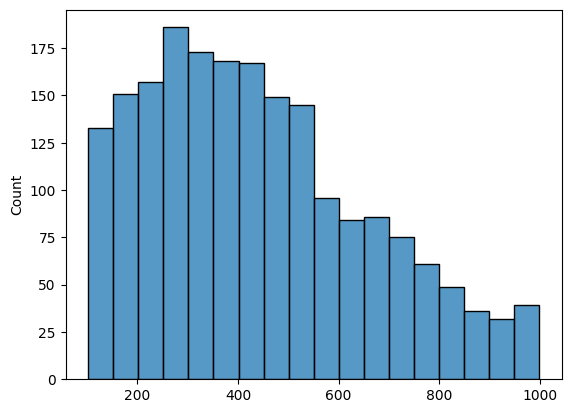

In [ ]:
len_list = []
for s in dl:
    len_list.append(len(s))
sns.histplot(len_list)

p = 0
n = 0
for labels in ll:
    found_pos = False
    for l in labels:
        if l:
            p += 1
            found_pos = True
            break
    if not found_pos:
        n+=1
print(f'{p = }\n{n = }')

# Train model multiple labels

In [ ]:
model = MultiClassifierCNN1D(num_classes=5, conv_channels=256, use_bias=True)
model.apply(init_weights)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
model

MultiClassifierCNN1D(
  (embedding): Embedding(21, 21)
  (conv1): Sequential(
    (0): Conv1d(21, 256, kernel_size=(3,), stride=(1,), padding=same)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=same)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=same)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AdaptiveMaxPool1d(output_size=1)
  )
  (fc1): Sequential(
    (0): Flatten(start_dim=1,

In [ ]:
trainer = TrainerMultipleClasses(model, loss_fn, optimizer, device)
df = trainer.train(epochs=50, train_iter=traindataloader, test_iter=testdataloader)

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
<ipython-input-6-1a27aa51fb67>:112: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row], axis=0)


[epoch 00] train-loss=1.1920 | test-loss=1.1838 | train-acc=0.4854 | test-acc=0.4060 | P=0.1438 | R=0.5181 | F1=0.2251
[epoch 01] train-loss=1.1665 | test-loss=1.1852 | train-acc=0.4055 | test-acc=0.4060 | P=0.1438 | R=0.5181 | F1=0.2251
[epoch 02] train-loss=1.1685 | test-loss=1.1838 | train-acc=0.4878 | test-acc=0.4060 | P=0.1438 | R=0.5181 | F1=0.2251
[epoch 03] train-loss=1.1643 | test-loss=1.1831 | train-acc=0.4173 | test-acc=0.5572 | P=0.1547 | R=0.3716 | F1=0.2185
[epoch 04] train-loss=1.1660 | test-loss=1.1844 | train-acc=0.5163 | test-acc=0.4196 | P=0.1551 | R=0.5589 | F1=0.2429
[epoch 05] train-loss=1.1647 | test-loss=1.1842 | train-acc=0.4210 | test-acc=0.5572 | P=0.1547 | R=0.3716 | F1=0.2185
[epoch 06] train-loss=1.1691 | test-loss=1.1840 | train-acc=0.4653 | test-acc=0.4553 | P=0.1849 | R=0.6662 | F1=0.2895
[epoch 07] train-loss=1.1669 | test-loss=1.1838 | train-acc=0.5508 | test-acc=0.4181 | P=0.1539 | R=0.5544 | F1=0.2409
[epoch 08] train-loss=1.1670 | test-loss=1.1853 

In [ ]:
df.to_csv('multi-label_classifier.csv')

# Figures

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


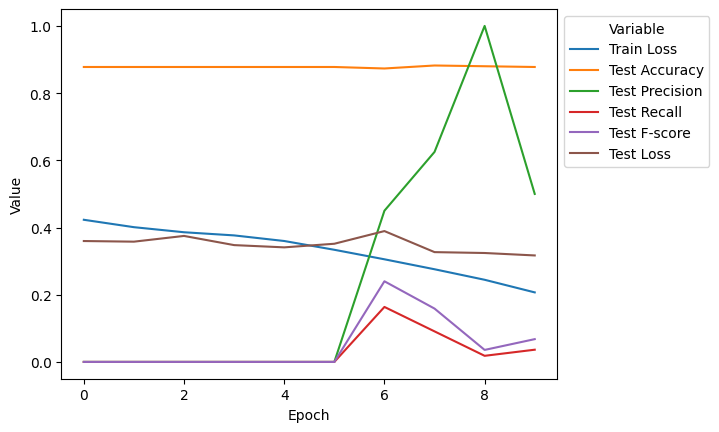

In [77]:
def reformat_df(df):
    df = df.drop(
        columns=['train_accuracy','train_precision','train_recall','train_fscore']
    )
    df = pd.melt(
        df,
        id_vars=['epoch'],
        value_vars=['train_loss','test_accuracy','test_precision','test_recall','test_fscore','test_loss']
    )
    df.rename(columns={'epoch': 'Epoch', 'variable': 'Variable', 'value': 'Value'}, inplace=True)
    # df = df.replace('train_accuracy', 'Train Accuracy')
    # df = df.replace('train_precision', 'Train Precision')
    # df = df.replace('train_recall', 'Train Recall')
    # df = df.replace('train_fscore', 'Train F-score')
    df = df.replace('train_loss', 'Train Loss')
    df = df.replace('test_accuracy', 'Test Accuracy')
    df = df.replace('test_precision', 'Test Precision')
    df = df.replace('test_recall', 'Test Recall')
    df = df.replace('test_fscore', 'Test F-score')
    df = df.replace('test_loss', 'Test Loss')
    return df


def reformat_df_hyper(df):
    df = df.drop(
        columns=['train_accuracy','train_precision','train_recall','train_fscore']
    )
    df = pd.melt(
        df,
        id_vars=['epoch', 'conv_channels', 'dropout_rate', 'lr', 'momentum'],
        value_vars=['train_loss','test_accuracy','test_precision','test_recall','test_fscore','test_loss']
    )
    df.rename(columns={'epoch': 'Epoch', 'variable': 'Variable', 'value': 'Value'}, inplace=True)
    # df = df.replace('train_accuracy', 'Train Accuracy')
    # df = df.replace('train_precision', 'Train Precision')
    # df = df.replace('train_recall', 'Train Recall')
    # df = df.replace('train_fscore', 'Train F-score')
    df = df.replace('train_loss', 'Train Loss')
    df = df.replace('test_accuracy', 'Test Accuracy')
    df = df.replace('test_precision', 'Test Precision')
    df = df.replace('test_recall', 'Test Recall')
    df = df.replace('test_fscore', 'Test F-score')
    df = df.replace('test_loss', 'Test Loss')
    return df


def plot_single_model(df, **kwargs):
    ax = sns.lineplot(df, x='Epoch', y='Value', hue='Variable')
    sns.move_legend(
        obj=ax,
        loc='upper left',
        bbox_to_anchor=(1, 1)
    )
    if 'filepath' in kwargs.keys():
        plt.savefig(kwargs['filepath'], format='svg', bbox_inches='tight')
        plt.clf()
    else:
        plt.show()


# Test case
df = pd.read_csv('GO_3A0005576.csv')
df = reformat_df(df)
plot_single_model(df)

In [72]:
go_csv = [
    "GO_3A0005576",
    "GO_3A0005739",
    "GO_3A0007165",
    "GO_3A0043066",
    "GO_3A0055085"
]


for go in go_csv:
    df = pd.read_csv(f'{go}.csv')
    df = reformat_df(df)
    plot_single_model(df, filepath=f'{go}.svg')


<Figure size 640x480 with 0 Axes>

In [88]:
sim_csv = [
    'half_neg_len200_500_n5000nr1',
    'half_pos_len200_500_n5000nr1'
]

for sim in sim_csv:
    df = pd.read_csv(f'{sim}.csv')
    df = reformat_df(df)
    plot_single_model(df, filepath=f'{sim}.svg')

<Figure size 640x480 with 0 Axes>

In [75]:
df = pd.read_csv('GO_3A0005576_full_set.csv')
df = reformat_df(df)
plot_single_model(df, filepath='GO_3A0005576_full_set.svg')

<Figure size 640x480 with 0 Axes>

In [84]:
df = pd.read_csv('hyperparameter_grid_len200_500_n5000nr1.csv')
df = reformat_df_hyper(df)

groups = df.groupby(['conv_channels', 'dropout_rate', 'lr', 'momentum'])

split_dfs = {name: group for name, group in groups}

for key in split_dfs.keys():
    sub_df = split_dfs[key]
    path = f'hyper_conv_channels_{key[0]}_dropout_{key[1]}_lr_{key[2]}_momentum_{key[3]}'.replace('.', '_') + '.svg'
    plot_single_model(sub_df, filepath=path)

<Figure size 640x480 with 0 Axes>